## Required Libraries & Files

In [ ]:
from PIL import Image, ImageDraw # Load Images & Draw Rectangles.
import torchvision.transforms as transforms # Tensor Transformation.
import torchvision.models as models # ResNet-18 PyTorch Model.
import matplotlib.pyplot as plt # Display Images.
from google.colab import drive # Load Google Drive files.
from torch import nn # Neural Network Layers
import torch # YOLO v5 Model
import time # Benchmark extraction
import os

In [ ]:
try:
    from google.colab import drive # Load Google Drive files.
    drive.mount('/content/drive', force_remount=True)
    projectPath = '/content/drive/Shareddrives/DeepLearning/FinalProject/'
except ModuleNotFoundError:
    projectPath = os.getcwd() + '/'

## System Configuration

In [ ]:
DetectionModel = 'Models/YOLO/Best.onnx'
ClassificationModel1 = 'Models/InceptionResNetV1/Age 0.60 + Gender 91.pt'
ClassificationModel2 = 'Models/ResNet-18/ResNet-18 Age 0.60 + Gender 93.pt'
Classes = 9
Groups = ['00-10', '11-20', '21-30', 
          '31-40', '41-50', '51-60', 
          '61-70', '71-80', '81-90']

runOn = "cuda:0" if torch.cuda.is_available() else "cpu"

## YOLO v5

In [ ]:
FaceDetector = torch.hub.load('ultralytics/yolov5', 
                              'custom', 
                              projectPath+'Models/YOLO/Best.onnx', 
                              _verbose=False)
FaceDetector.eval()
FaceDetector.to(runOn);

## InceptionResNetV1 / ResNet-18

#### InceptionResNetV1

In [ ]:
!pip install facenet_pytorch

In [ ]:
from facenet_pytorch import InceptionResnetV1

FaceClassifier = InceptionResnetV1(pretrained='vggface2', classify=True)

FaceClassifier.logits = nn.Linear(512, Classes+2, bias=True)
FaceClassifier = nn.Sequential(FaceClassifier, nn.Dropout(0.5))
FaceClassifier = nn.Sequential(FaceClassifier, nn.Sigmoid())

FaceClassifier.load_state_dict(torch.load(projectPath + ClassificationModel1))
FaceClassifier.eval()

FaceClassifier.to(runOn);

#### ResNet-18 (Faster)

In [ ]:
FaceClassifier = models.resnet18(pretrained=True)

FaceClassifier.fc = nn.Linear(512, Classes+2)
FaceClassifier = nn.Sequential(FaceClassifier, nn.Sigmoid())

FaceClassifier.load_state_dict(torch.load(projectPath + ClassificationModel2))

FaceClassifier.eval()
FaceClassifier.to(runOn);

## Utilities

In [ ]:
transform = transforms.Compose([transforms.ToTensor()])

def extractFace(IMG, FaceDetector, threshold=0.50, returnFace=True):
    extractedFaces = []
    extractedBoxes = []
    FaceDetections = FaceDetector(IMG).pandas().xyxy[0]
    for detection in FaceDetections.values:
        xmin, ymin, xmax, ymax, confidence = detection[:5]
        if confidence >= threshold:
            bb = [(xmin, ymin), (xmax, ymax)]
            if returnFace:
                w, h = xmax - xmin, ymax - ymin
                currentFace = IMG.crop((xmin, ymin, w+xmin, h+ymin))
                extractedFaces.append(currentFace)
            extractedBoxes.append(bb)

    return extractedFaces, extractedBoxes

def readImage(IMG):
    IMG = IMG.convert('RGB')
    IMG = IMG.resize((200, 200))
    tensorIMG = transform(IMG).unsqueeze(0)
    return tensorIMG

def extractInfo(MyModel, tensorIMG, Verbosity=False):
    tensorIMG = tensorIMG.to(runOn)
    tensorLabels = MyModel(tensorIMG)[0]

    Age = torch.argmax(tensorLabels[:Classes])
    Gender = int(torch.argmax(tensorLabels[Classes:]))
    Gender = 'Male' if Gender == 0 else 'Female'

    C1 = float(torch.max(tensorLabels[:Classes]))
    C2 = float(torch.max(tensorLabels[Classes:]))

    if Verbosity: 
        output = [round(float(x), 3) for x in tensorLabels]
        print(output)
    return Groups[Age], Gender, [round(C1, 3), round(C2, 3)]

In [ ]:
def returnAnalysis(imagePath):
    IMG = Image.open(imagePath)
    IMG_ = ImageDraw.Draw(IMG)
    t0 = time.time()
    faces, bbs = extractFace(IMG, FaceDetector, 0.7)
    tt1 = time.time() - t0

    tt2 = 0
    for face, bb in zip(faces, bbs):
        IMG_.rectangle(bb, outline ="Red", width=2)
        tensorIMG = readImage(face)
        t0 = time.time()
        Age, Gender, C = extractInfo(FaceClassifier, tensorIMG)
        tt = time.time() - t0
        tt2 += tt
        textBox = f'{Age} {Gender}'
        Text = ImageDraw.Draw(IMG)
        Text.text((bb[0][0]+5, bb[0][1]+2), 
                    textBox, 
                    fill=(255, 0, 0))
    return IMG, tt1+tt2

Extraction Time: 0.053


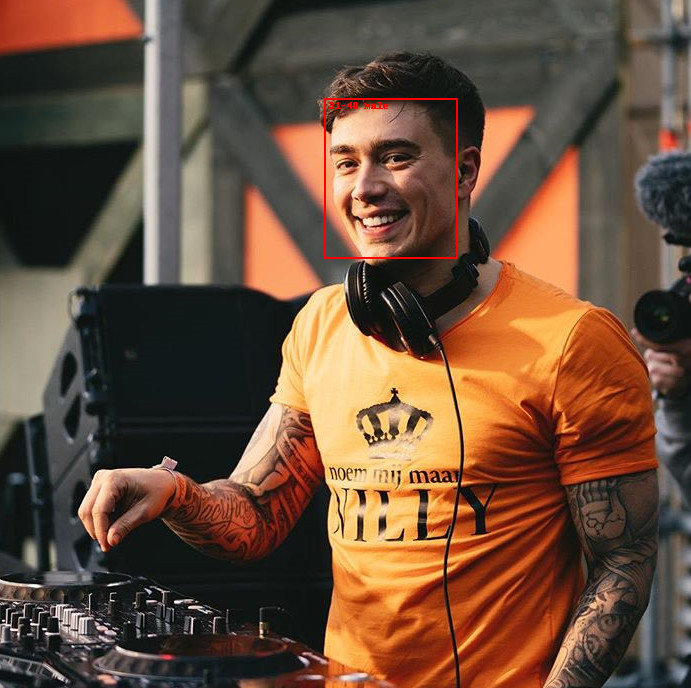

In [ ]:
IMG, tt = returnAnalysis(projectPath+'DATA/WIDER_TEST/Image1.jpg')
print(f"Extraction Time: {round(tt, 3)}")
IMG

## WebCam Video

In [ ]:
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode, b64encode
import cv2, PIL, io, html, time
import numpy as np

In [ ]:
def returnAnalysis(IMG):
    facesData = []
    IMG = Image.fromarray(IMG)
    faces, bbs = extractFace(IMG, FaceDetector, 0.7)
    for face, bb in zip(faces, bbs):
        tensorIMG = readImage(face)

        Age, Gender, C = extractInfo(FaceClassifier, tensorIMG)

        textBox = f'{Age} {Gender}'
        facesData.append(textBox)

    return bbs, facesData

In [ ]:
# function to convert OpenCV Rectangle bounding box image into base64 byte string to be overlayed on video stream
def bbox_to_bytes(bbox_array):
  """
  Params:
          bbox_array: Numpy array (pixels) containing rectangle to overlay on video stream.
  Returns:
        bytes: Base64 image byte string
  """
  # convert array into PIL image
  bbox_PIL = PIL.Image.fromarray(bbox_array, 'RGBA')
  iobuf = io.BytesIO()
  # format bbox into png for return
  bbox_PIL.save(iobuf, format='png')
  # format return string
  bbox_bytes = 'data:image/png;base64,{}'.format((str(b64encode(iobuf.getvalue()), 'utf-8')))

  return bbox_bytes
  
# function to convert the JavaScript object into an OpenCV image
def js_to_image(js_reply):
  """
  Params:
          js_reply: JavaScript object containing image from webcam
  Returns:
          img: OpenCV BGR image
  """
  # decode base64 image
  image_bytes = b64decode(js_reply.split(',')[1])
  # convert bytes to numpy array
  jpg_as_np = np.frombuffer(image_bytes, dtype=np.uint8)
  # decode numpy array into OpenCV BGR image
  img = cv2.imdecode(jpg_as_np, flags=1)

  return img

# JavaScript to properly create our live video stream using our webcam as input
def video_stream():
  js = Javascript('''
    var video;
    var div = null;
    var stream;
    var captureCanvas;
    var imgElement;
    var labelElement;
    
    var pendingResolve = null;
    var shutdown = false;
    
    function removeDom() {
       stream.getVideoTracks()[0].stop();
       video.remove();
       div.remove();
       video = null;
       div = null;
       stream = null;
       imgElement = null;
       captureCanvas = null;
       labelElement = null;
    }
    
    function onAnimationFrame() {
      if (!shutdown) {
        window.requestAnimationFrame(onAnimationFrame);
      }
      if (pendingResolve) {
        var result = "";
        if (!shutdown) {
          captureCanvas.getContext('2d').drawImage(video, 0, 0, 640, 480);
          result = captureCanvas.toDataURL('image/jpeg', 0.8)
        }
        var lp = pendingResolve;
        pendingResolve = null;
        lp(result);
      }
    }
    
    async function createDom() {
      if (div !== null) {
        return stream;
      }

      div = document.createElement('div');
      div.style.border = '2px solid black';
      div.style.padding = '3px';
      div.style.width = '100%';
      div.style.maxWidth = '600px';
      document.body.appendChild(div);
      
      const modelOut = document.createElement('div');
      modelOut.innerHTML = "<span>Status:</span>";
      labelElement = document.createElement('span');
      labelElement.innerText = 'No data';
      labelElement.style.fontWeight = 'bold';
      modelOut.appendChild(labelElement);
      div.appendChild(modelOut);
           
      video = document.createElement('video');
      video.style.display = 'block';
      video.width = div.clientWidth - 6;
      video.setAttribute('playsinline', '');
      video.onclick = () => { shutdown = true; };
      stream = await navigator.mediaDevices.getUserMedia(
          {video: { facingMode: "environment"}});
      div.appendChild(video);

      imgElement = document.createElement('img');
      imgElement.style.position = 'absolute';
      imgElement.style.zIndex = 1;
      imgElement.onclick = () => { shutdown = true; };
      div.appendChild(imgElement);
      
      video.srcObject = stream;
      await video.play();

      captureCanvas = document.createElement('canvas');
      captureCanvas.width = 640; //video.videoWidth;
      captureCanvas.height = 480; //video.videoHeight;
      window.requestAnimationFrame(onAnimationFrame);
      
      return stream;
    }
    async function stream_frame(label, imgData) {
      if (shutdown) {
        removeDom();
        shutdown = false;
        return '';
      }

      var preCreate = Date.now();
      stream = await createDom();
      
      var preShow = Date.now();
      if (label != "") {
        labelElement.innerHTML = label;
      }
            
      if (imgData != "") {
        var videoRect = video.getClientRects()[0];
        imgElement.style.top = videoRect.top + "px";
        imgElement.style.left = videoRect.left + "px";
        imgElement.style.width = videoRect.width + "px";
        imgElement.style.height = videoRect.height + "px";
        imgElement.src = imgData;
      }
      
      var preCapture = Date.now();
      var result = await new Promise(function(resolve, reject) {
        pendingResolve = resolve;
      });
      shutdown = false;
      
      return {'create': preShow - preCreate, 
              'show': preCapture - preShow, 
              'capture': Date.now() - preCapture,
              'img': result};
    }
    ''')

  display(js)
  
def video_frame(label, bbox):
  data = eval_js('stream_frame("{}", "{}")'.format(label, bbox))
  return data

In [ ]:
def draw_label(img, text, pos, bg_color):
   font_face = cv2.FONT_HERSHEY_SIMPLEX
   scale = 0.4
   color = (0, 0, 0)
   thickness = cv2.FILLED
   margin = 2
   txt_size = cv2.getTextSize(text, font_face, scale, thickness)

   end_x = int(pos[0] + txt_size[0][0] + margin)
   end_y = int(pos[1] - txt_size[0][1] - margin)

   cv2.rectangle(img, pos, (end_x, end_y), bg_color, thickness)
   cv2.putText(img, text, pos, font_face, scale, color, 1, cv2.LINE_AA)

In [ ]:
# start streaming video from webcam
video_stream()
# label for video
label_html = ' No Face'
# initialze bounding box to empty
bbox = ''

while True:
    jsReply = video_frame(label_html, bbox)
    if not jsReply: break

    IMG = js_to_image(jsReply["img"])
    bbox_array = np.zeros([480, 640, 4], dtype=np.uint8)

    boundingBoxes, facesData = returnAnalysis(IMG)
    if len(boundingBoxes) > 0: label_html = ' '
    else: label_html = ' No Face'
    for bb, data in zip(boundingBoxes, facesData):
      (x, y), (w, h) = bb
      bbox_array = cv2.rectangle(bbox_array, (int(x),int(y)), (int(w),int(h)),(255,0,0), 2)
      label_html += data + ' '
    
    bbox_array[:,:,3] = (bbox_array.max(axis = 2) > 0 ).astype(int) * 255
    bbox_bytes = bbox_to_bytes(bbox_array)
    bbox = bbox_bytes

<IPython.core.display.Javascript object>

## Offline Video Detection

The video detection does not work on Google Colab, so the only way to do this is offline using Jupyter Notebook.

In [ ]:
import cv2

In [ ]:
videoPath = '/home/sklyvan/Downloads/Act of Rage & Rejecta.mp4'

name, extension = videoPath.split('/')[-1].split('.')
newName = name + ' (FaceDetection)' + '.avi'
newPath = '/'.join(videoPath.split('/')[:-1]) + '/' + newName

output = cv2.VideoWriter(newPath, cv2.VideoWriter_fourcc('M','J','P','G'), 20, (1920, 1080))

print(f"Output to: {newPath}")

In [ ]:
def returnAnalysis(IMG):
    facesData = []
    IMG = Image.fromarray(IMG)
    faces, bbs = extractFace(IMG, FaceDetector, 0.5)
    for face, bb in zip(faces, bbs):
        tensorIMG = readImage(face)

        Age, Gender, C = extractInfo(FaceClassifier, tensorIMG)

        textBox = f'{Age} {Gender}'
        facesData.append(textBox)

    return bbs, facesData

In [ ]:
def draw_label(img, text, pos, bg_color):
    font_face = cv2.FONT_HERSHEY_SIMPLEX
    scale = 0.4
    color = (0, 0, 0)
    thickness = cv2.FILLED
    margin = 2
    txt_size = cv2.getTextSize(text, font_face, scale, thickness)
    
    end_x = pos[0] + txt_size[0][0] + margin
    end_y = pos[1] - txt_size[0][1] - margin

    cv2.rectangle(img, pos, (end_x, end_y), bg_color, thickness)
    cv2.putText(img, text, pos, font_face, scale, color, 1, cv2.LINE_AA)

In [ ]:
videoCapture = cv2.VideoCapture(videoPath)

while videoCapture.isOpened():
    isCorrect, lastFrame = videoCapture.read()
    if isCorrect:
        BoundingBoxes, Labels = returnAnalysis(lastFrame)
        for bb, lbl in zip(BoundingBoxes, Labels):
            (x, y), (w, h) = bb
            print('Face!')
            cv2.rectangle(lastFrame, (int(x),int(y)), (int(w),int(h)), (255,0,0), 2)
            draw_label(lastFrame, lbl, (int(x),int(y)), (255, 0, 0))
            
        output.write(lastFrame)
        cv2.imshow('Frame', lastFrame)
        Key = cv2.waitKey(20)
        if Key == ord('q'): break
    else:
        break
else:
    print("Something went wrong.")
        
videoCapture.release()
cv2.destroyAllWindows()